<a href="https://colab.research.google.com/github/rjrizani/machine-learning/blob/main/Emotions_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import gdown
import numpy as np

In [2]:
google_drive_link = "https://drive.google.com/file/d/12iVo49pHF7T_tiQRzcF_PDAYCN1rcLLi/view?usp=drive_link"
file_id = re.search(r"/d/(\w+)/", google_drive_link).group(1)

In [3]:
output_file = 'fer2013.csv'

gdown.download(f'https://drive.google.com/uc?id={file_id}', output_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=12iVo49pHF7T_tiQRzcF_PDAYCN1rcLLi
From (redirected): https://drive.google.com/uc?id=12iVo49pHF7T_tiQRzcF_PDAYCN1rcLLi&confirm=t&uuid=efba7573-baad-4c17-b847-1089e606c261
To: /content/fer2013.csv
100%|██████████| 301M/301M [00:08<00:00, 36.0MB/s]


'fer2013.csv'

In [4]:
data = pd.read_csv('fer2013.csv')

In [5]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   Usage    35887 non-null  object
 2   pixels   35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [7]:
data['Usage'].value_counts()

,count
Usage,
Training,28709
PublicTest,3589
PrivateTest,3589


In [8]:
data['emotion'].value_counts()

,count
emotion,
3,8989
6,6198
4,6077
2,5121
0,4953
5,4002
1,547


In [9]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

#Data Processing


In [10]:
#function to tranform raw pixel data and label into format ML tasks
def prepare_data(data):
  image_array = np.zeros(shape=(len(data), 48, 48))
  image_label = np.array(list(map(int, data['emotion'])))

  for i, row in enumerate(data.index):
    image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
    image = np.reshape(image, (48, 48))
    image_array[i] = image

  return image_array, image_label

In [11]:
train_image_array, train_image_label = prepare_data(data[data['Usage'] == 'Training'])
val_image_array, val_image_label = prepare_data(data[data['Usage'] == 'PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data['Usage'] == 'PublicTest'])

## Reshape and scale the images

In [12]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))

In [13]:
#data type conversion and normalization
#convert pixel value to floating poin numbers and normalize them
train_images = train_images.astype('float32') / 255
val_images = val_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

##one hot encode(OHE) the emotion label

In [14]:
from keras.utils import to_categorical

In [15]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

In [16]:
#Calculate class weights for handling imbalance data in the training dataset
class_weight = dict(
    zip(
        range(0,7), #emotion label from 0  to 6
        (((data[data['Usage'] == 'Training']['emotion'].value_counts()).sort_index()) /
         len(data[data['Usage'] == 'Training'])).tolist()
    )
)

In [17]:
print(class_weight)

{0: 0.1391549688251071, 1: 0.01518687519593159, 2: 0.14270786164617366, 3: 0.2513149186666202, 4: 0.16823992476226968, 5: 0.11045316799609878, 6: 0.17294228290779895}


Data Visualization


In [18]:
import matplotlib.pyplot as plt

def plot_all_emotions():
  fig, axs = plt.subplots(1, 7, figsize=(30, 12))   #1 row and 7 columns
  fig.subplots_adjust(hspace=.2, wspace=.2)
  axs  = axs.ravel()    #flatten the array for easier interation

  for i in range(7):
    #find fist index of first image
    idx = data[data['emotion'] == i].index[0]

    #display the image
    axs[i].imshow(np.fromstring(data.loc[idx, 'pixels'], dtype=int, sep=' ').reshape(48, 48), cmap='gray')
    axs[i].set_title(emotions[i], fontsize=30)

In [19]:
print(data[data['emotion'] == 5].index[0])

15


In [20]:
print(data[data['emotion'] == 5])

       emotion        Usage                                             pixels
15           5     Training  107 107 109 109 109 109 110 101 123 140 144 14...
26           5     Training  162 200 187 180 197 198 196 192 176 152 136 11...
29           5     Training  50 44 74 141 187 187 169 113 80 128 181 172 76...
39           5     Training  68 69 67 60 55 50 45 47 50 48 43 41 45 48 48 4...
51           5     Training  1 1 5 9 6 3 13 64 100 90 114 122 132 139 147 1...
...        ...          ...                                                ...
35857        5  PrivateTest  253 255 229 150 89 61 54 60 55 49 61 50 56 45 ...
35863        5  PrivateTest  196 196 197 197 198 198 198 196 176 148 122 10...
35872        5  PrivateTest  131 159 90 59 10 0 1 1 1 0 1 1 0 0 2 2 5 7 9 1...
35874        5  PrivateTest  43 43 51 73 94 97 102 95 99 107 126 144 154 17...
35875        5  PrivateTest  248 251 239 144 102 95 82 77 91 138 153 145 14...

[4002 rows x 3 columns]


In [21]:
for i in range(7):
  print(i)

0
1
2
3
4
5
6


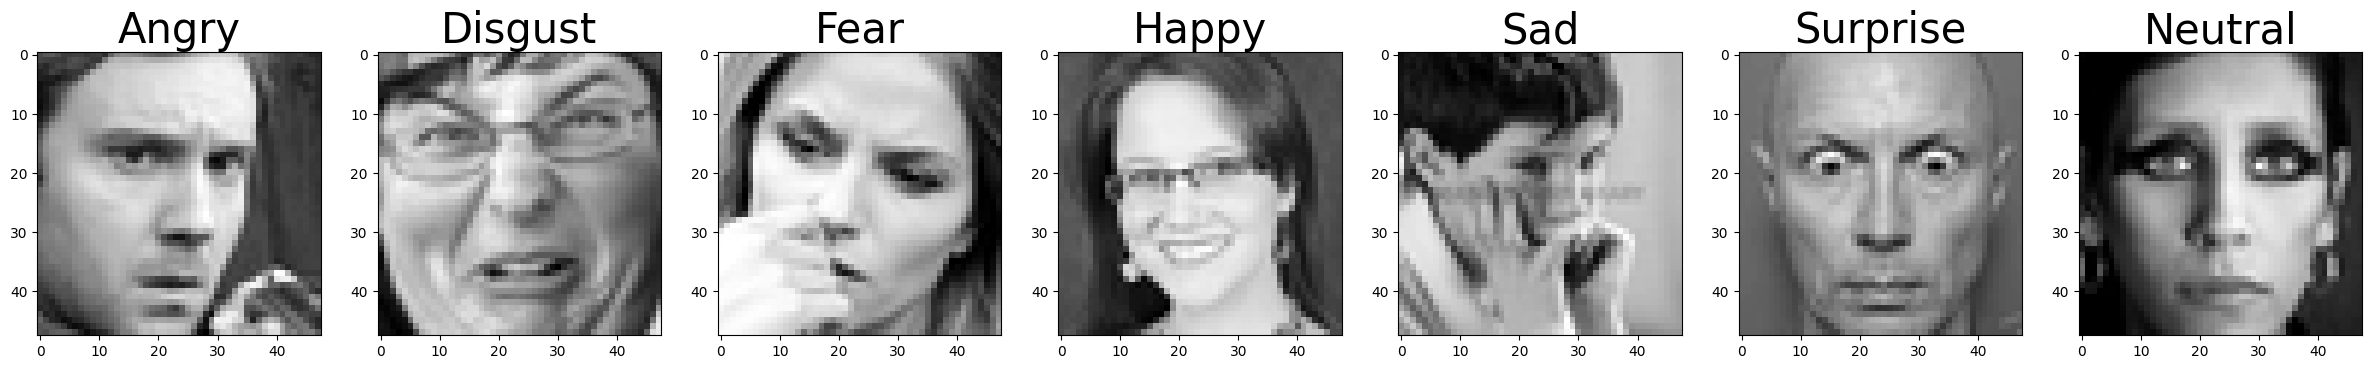

In [22]:
plot_all_emotions()

In [23]:
def plot_emotion(emotion_label=0):
  fig,axs = plt.subplots(1, 5, figsize=(30, 12))
  fig.subplots_adjust(hspace=.2, wspace=.2)
  axs = axs.ravel()

  for i in range(5):
    #find fist index of first image
    idx = data[data['emotion'] == emotion_label].index[i]

    #display the image
    axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
    axs[i].set_title(emotions[emotion_label], fontsize=30)

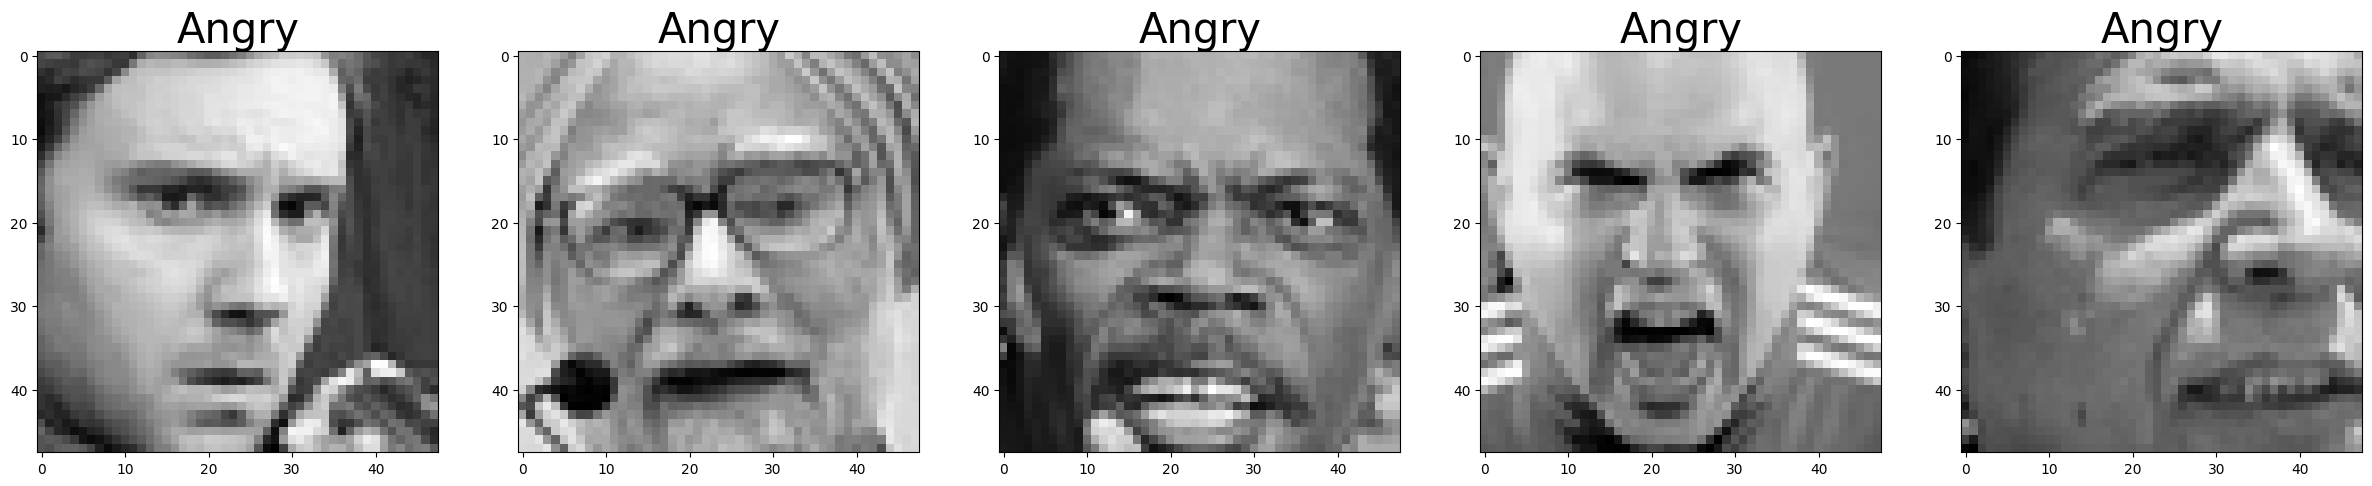

In [24]:
plot_emotion()

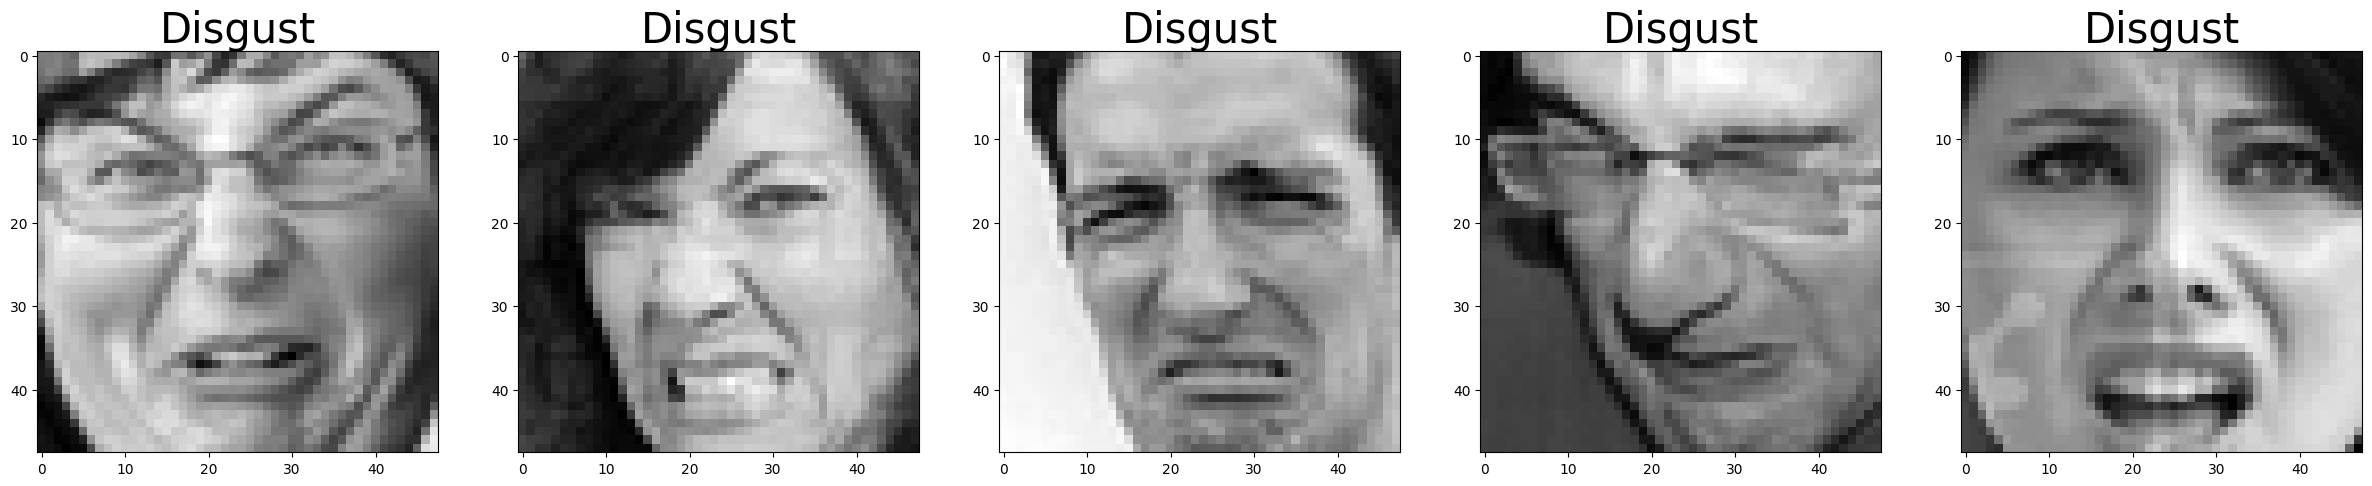

In [25]:
plot_emotion(emotion_label=1)

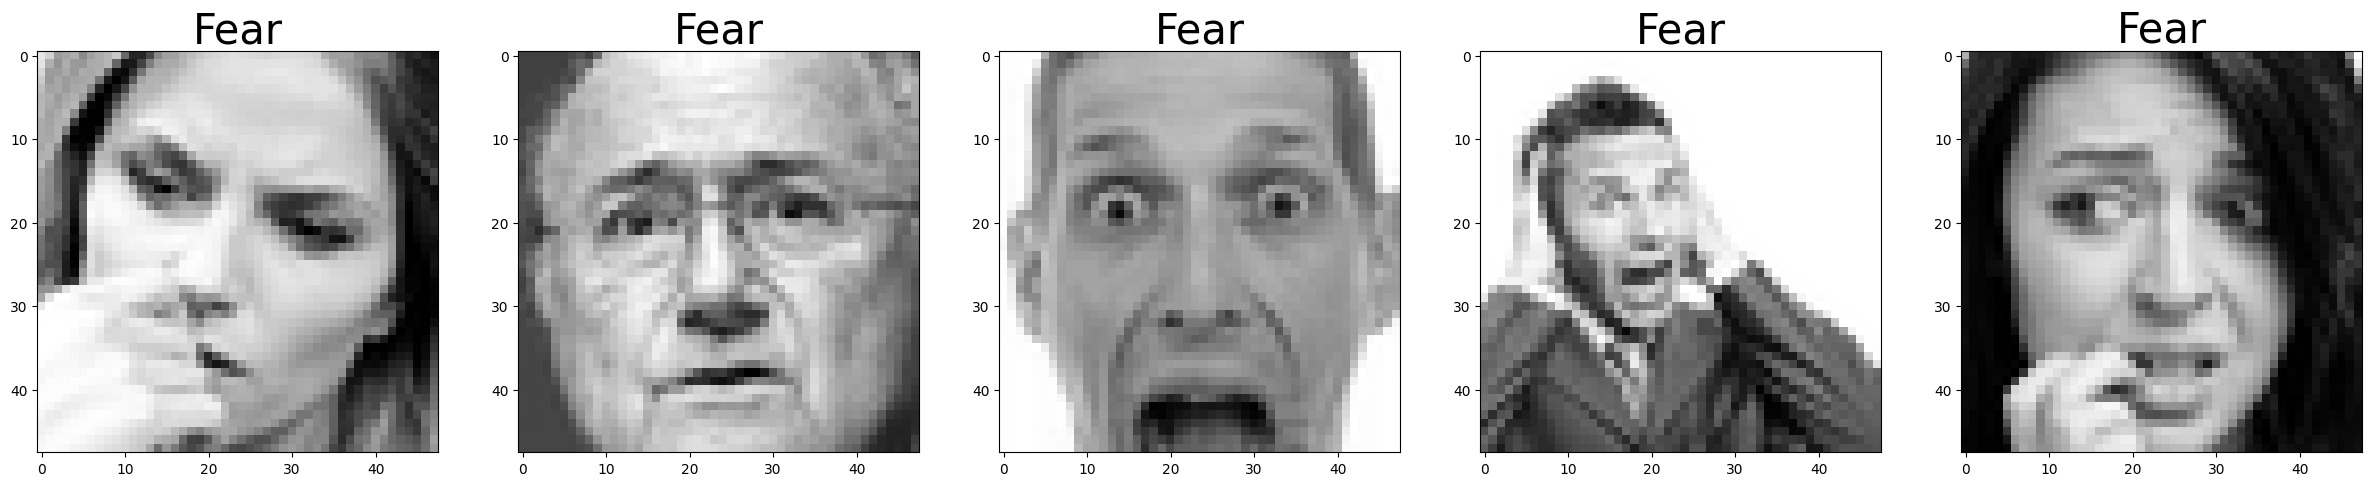

In [26]:
plot_emotion(emotion_label=2)

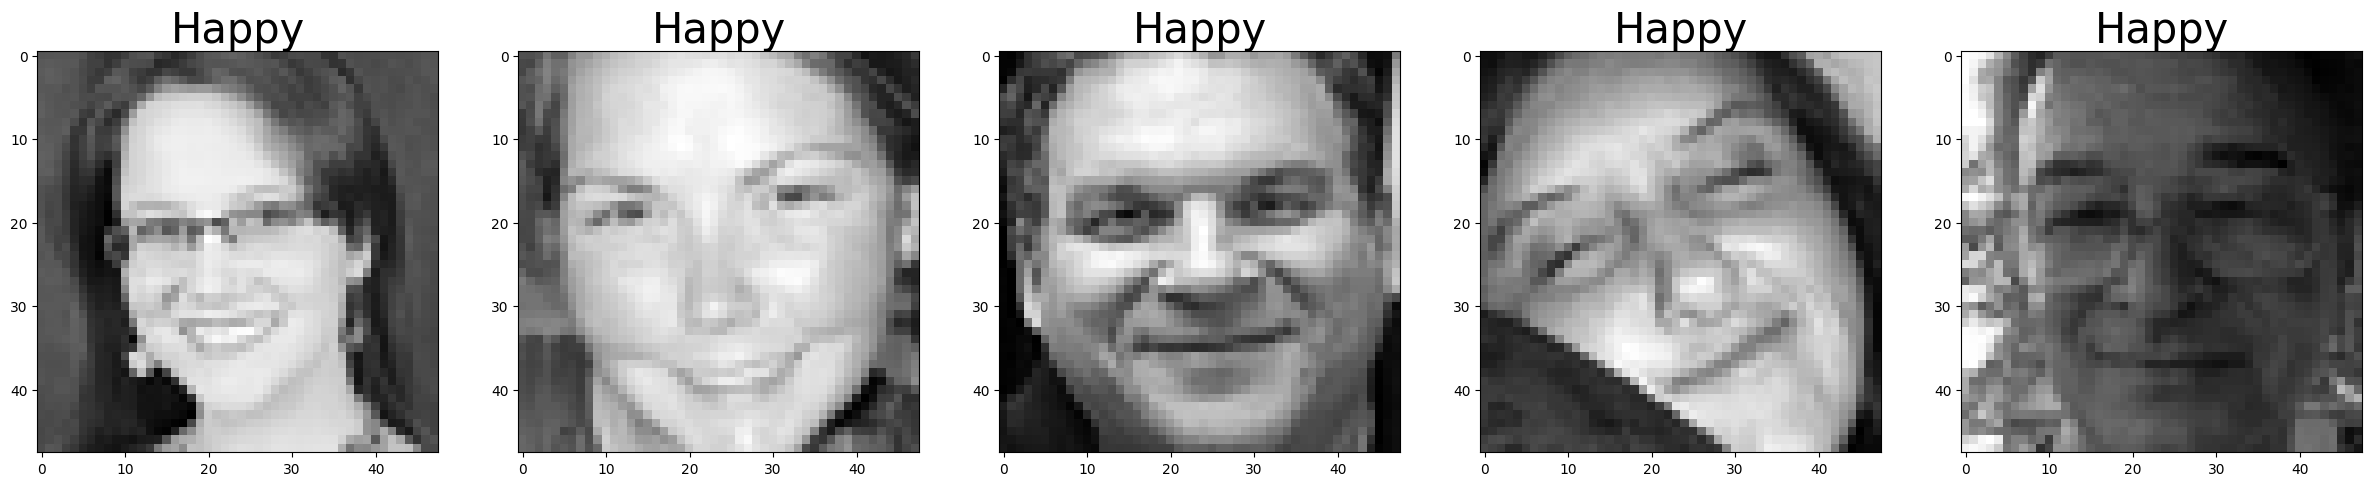

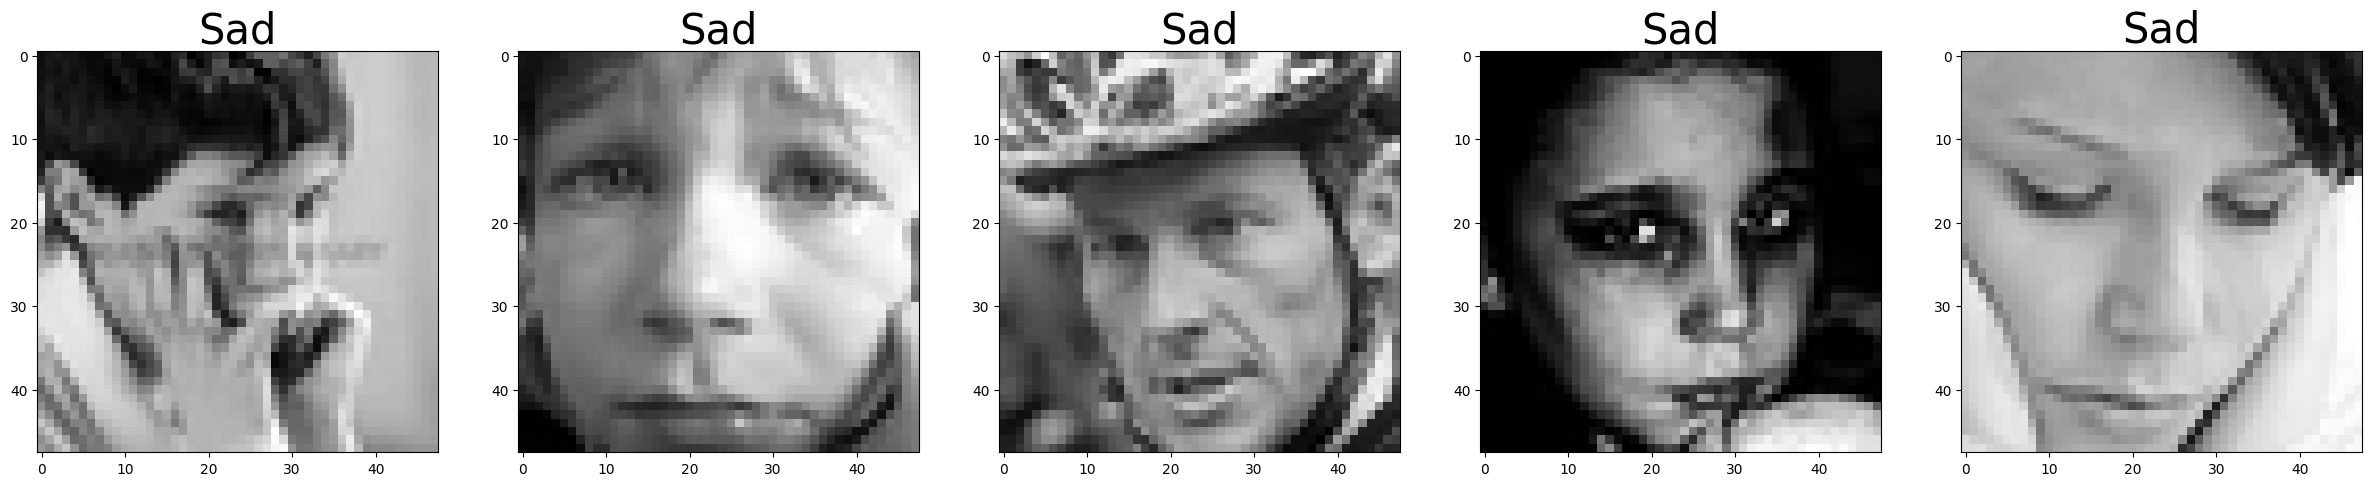

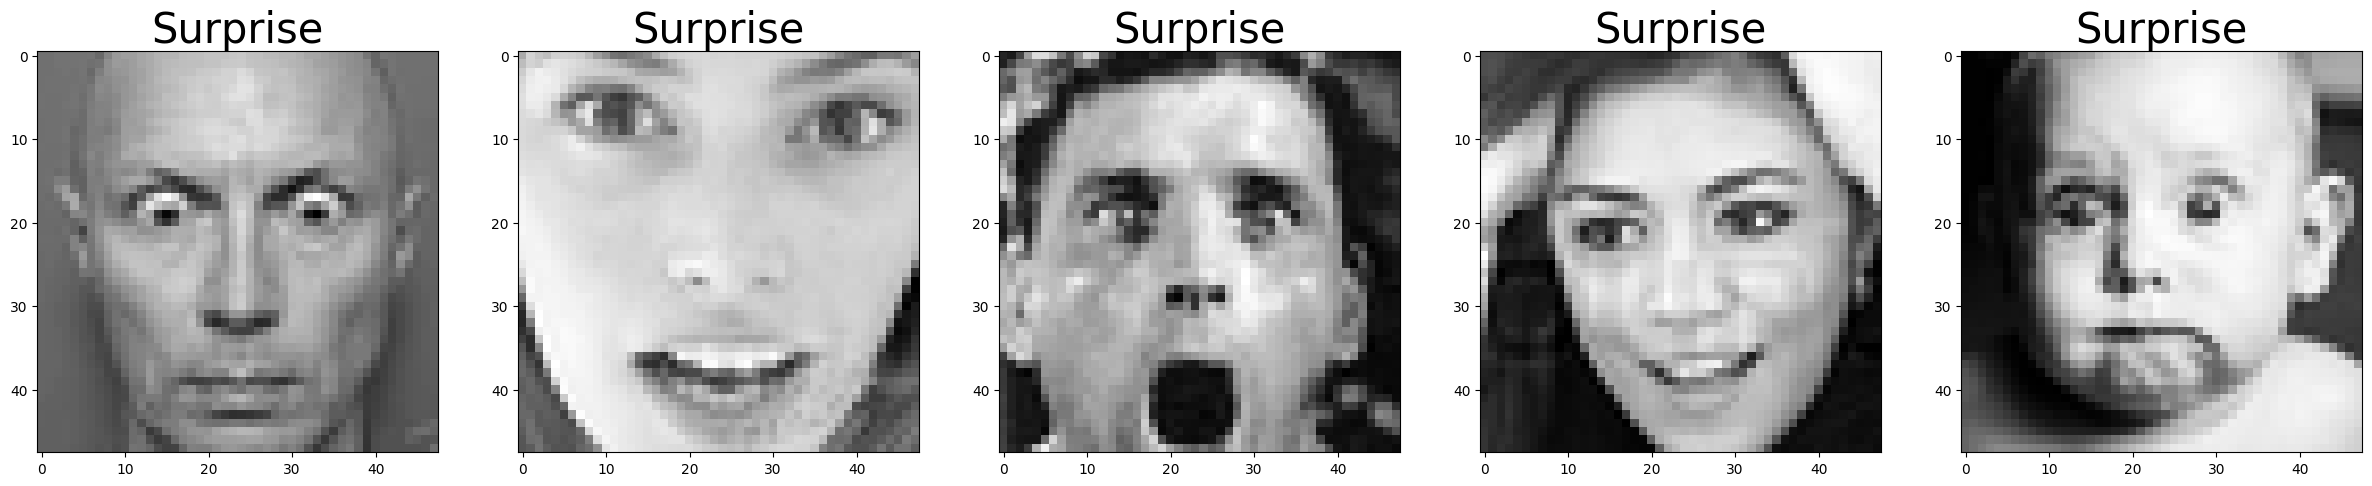

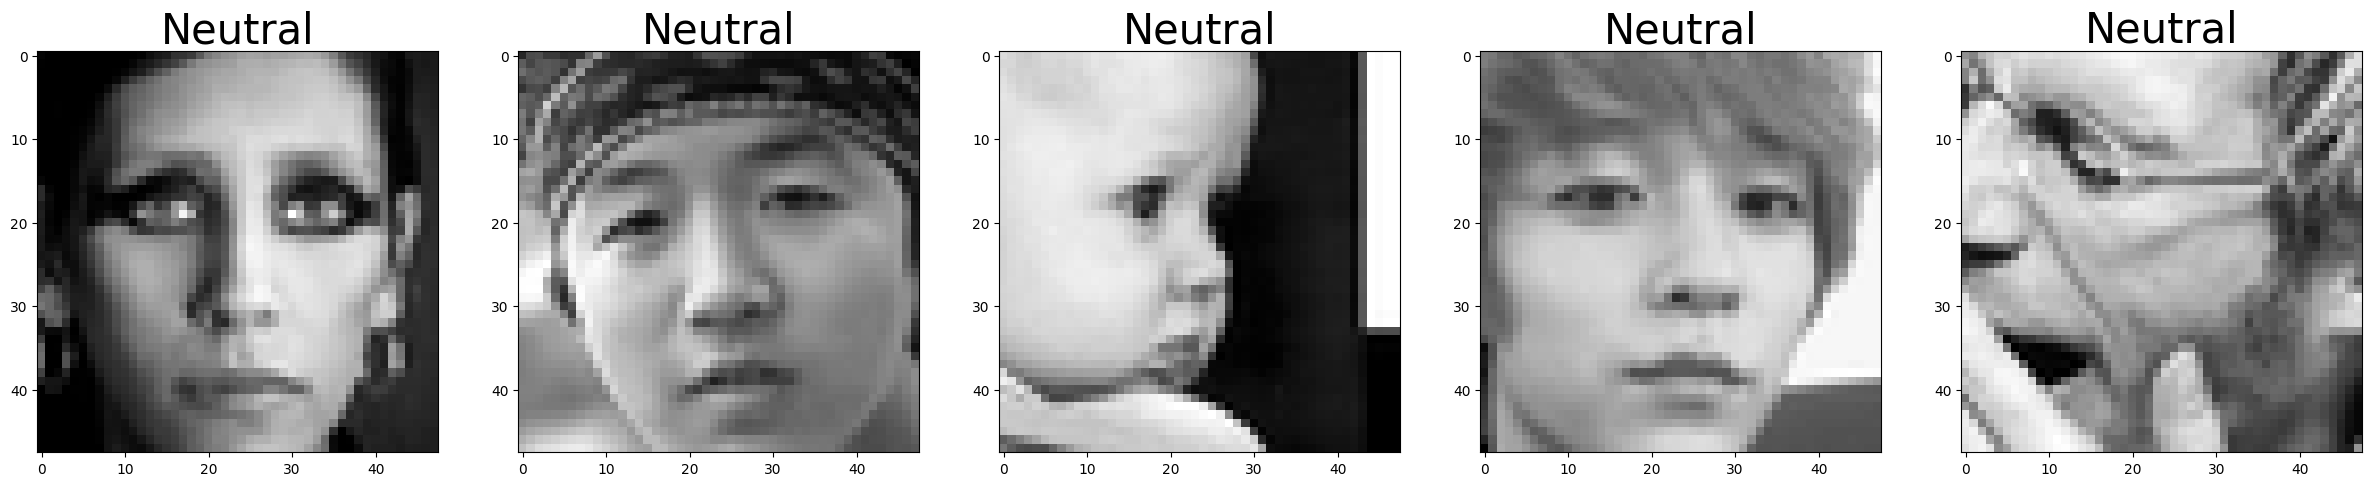

In [27]:
for i in range(3,7):
  plot_emotion(emotion_label=i)

Compare and plot the distributions of emotion labels in multiple datasets.

    Parameters:
    - arrays: A list of datasets with one-hot encoded emotion labels.
    - colors: A list of colors for the plots.
    - titles: A list of titles for each dataset's distribution plot.



In [31]:
import random
def plot_distributions(arrays, colors, titles):
    fig, axs = plt.subplots(1, len(arrays), figsize=(6* len(arrays), 6), sharey=False)
    fig.subplots_adjust(hspace=.2, wspace=.2)
    axs = axs.ravel()
    x = emotions.values()

    for i, array in enumerate(arrays):
        df_array = pd.DataFrame()
        df_array['emotion'] = array.argmax(axis=1)
        y = df_array['emotion'].value_counts()
        keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
        for key_missed in keys_missed:
            y[key_missed] = 0
        axs[i].bar(x,y.sort_index(), color= colors[i])
        axs[i].set_title(titles[i])
        axs[i].grid()




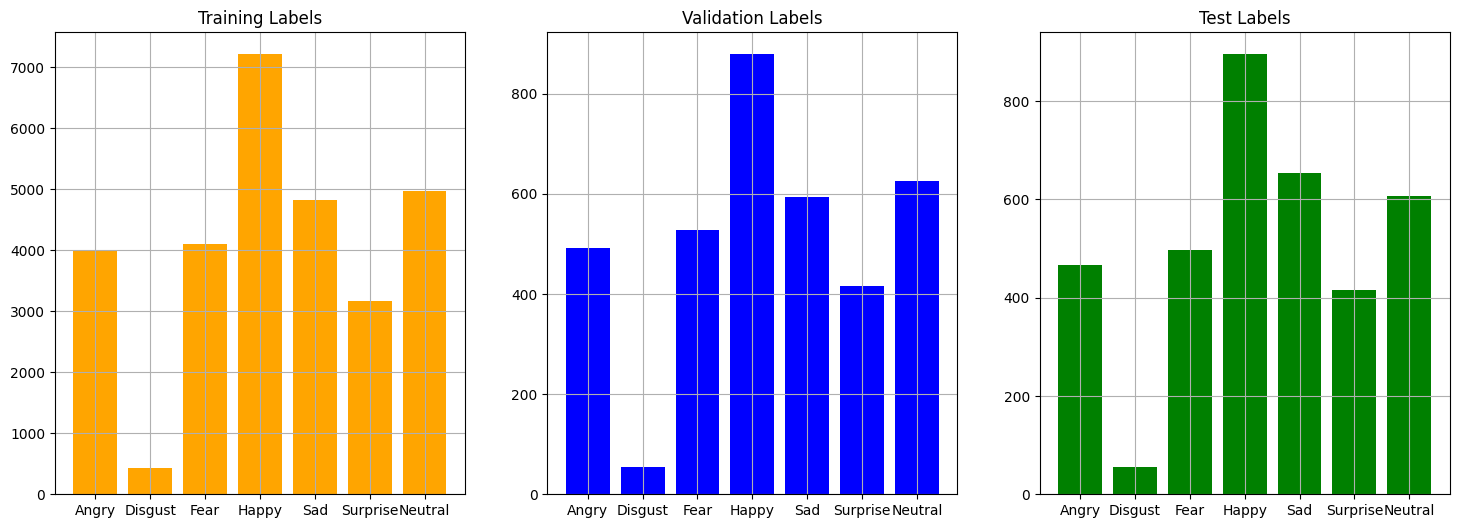

In [32]:
arrays = [train_labels, val_labels, test_labels]
colors = ["orange", "blue", "green"]
titles = ["Training Labels", "Validation Labels", "Test Labels"]
plot_distributions(arrays, colors, titles)
plt.show()